# Ungraded Lab: Building Models for the IMDB Reviews Dataset

In this lab, you will build four models and train it on the [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) with full word encoding. These use different layers after the embedding namely `Flatten`, `LSTM`, `GRU`, and `Conv1D`. You will compare the performance and see which architecture might be best for this particular dataset. Let's begin!

## Imports

You will first import common libraries that will be used throughout the exercise.

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Download and Prepare the Dataset

Next, you will download the `plain_text` version of the `IMDB Reviews` dataset.

In [2]:
# The dataset is already downloaded for you. For downloading you can use the code below.
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="../data/", download=False)

In [3]:
# Get the train and test sets
train_dataset, test_dataset = imdb['train'], imdb['test']

Then, you will build the vocabulary based on the training set.

In [4]:
# Vectorization and Padding Parameters

VOCAB_SIZE = 10000
MAX_LENGTH = 120
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [5]:
# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# Get the string inputs and integer outputs of the training set
train_reviews = train_dataset.map(lambda review, label: review)

# Generate the vocabulary based only on the training set
vectorize_layer.adapt(train_reviews)

# Delete because it's no longer needed
del train_reviews

In Week 2, you generated the padded sequences by chaining `map()` and `apply()` methods. Here's a similar way to do that. You will just call an `apply()` then do the transformations in one preprocessing function.

In [6]:
def preprocessing_fn(dataset):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Apply the vectorization layer to the string features
  dataset_sequences = dataset.map(
      lambda text, label: (vectorize_layer(text), label)
      )

  # Put all elements in a single ragged batch
    # First, you can expand along the 0 axis for each data point
  
  dataset_sequences = dataset_sequences.map(lambda text, label: (tf.expand_dims(text, 0),label))
# Then create a RaggedTensor with a ragged rank of 1
  dataset_sequences = dataset_sequences.map(lambda text, label: (tf.RaggedTensor.from_tensor(text),label))
# Create batches
  dataset_sequences = dataset_sequences.batch(dataset_sequences.cardinality())
# Squeeze the extra dimension from the created batches
  dataset_sequences = dataset_sequences.map(lambda text, label: (tf.squeeze(text, axis=1),label))

  # Output a tensor from the single batch. Extract the sequences and labels.
  sequences, labels = dataset_sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(
      sequences.numpy(),
      maxlen=MAX_LENGTH,
      truncating=TRUNC_TYPE,
      padding=PADDING_TYPE
      )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
  labels = tf.data.Dataset.from_tensor_slices(labels)

  # Combine the padded sequences and labels
  dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

  return dataset_vectorized

In [7]:
# Preprocess the train and test data
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)

View a couple of examples. You should see tuples of tensors with a padded sequence and label.

In [8]:
# View 2 training sequences and its labels
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,   11,   14,   34,  412,  384,   18,   90,
         28,    1,    8,   33, 1322, 3560,   42,  487,    1,  191,   24,
         85,  152,   19,   11,  217,  316,   28,   65,  240,  214,    8,
        489,   54,   65,   85,  112,   96,   22, 5596,   11,   93,  642,
        743,   11,   18,    7,   34,  394, 9522,  170, 2464,  408,    2,
         88, 1216,  137,   66,  144,   51,    2,    1, 7558,   66,  245,
         65, 2870,   16,    1, 2860,    1,    1, 1426, 5050,    3,   40,
          1, 1579,   17, 3560,   14,  158,   19,    4, 1216,  891, 8040,
          8,    4,   18,   12,   14, 4059,    5,   99,  146, 1241,   10,
        237,  704,   12,   48,   24,   93,   39,   11, 7339,  152,   39,
       1322,    1,   50,  398,   10,   96, 1155,  851,  141,    9])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,   10,

You will do the optimization and batching as usual.

In [9]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize and batch the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

## Plot Utility

The function below will visualize the accuracy and loss history after training.

In [10]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

## Model 1: Flatten

First up is simply using a `Flatten` layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

In [11]:
# Parameters
EMBEDDING_DIM = 16
DENSE_DIM = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [12]:
NUM_EPOCHS = 10

# Train the model
history_flatten = model_flatten.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=(test_dataset_final))

Epoch 1/10
782/782 [==============================] - 11s 7ms/step - loss: 0.5019 - accuracy: 0.7354 - val_loss: 0.3818 - val_accuracy: 0.8266
Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 0.2342 - accuracy: 0.9114 - val_loss: 0.4317 - val_accuracy: 0.8150
Epoch 3/10
782/782 [==============================] - 5s 7ms/step - loss: 0.0845 - accuracy: 0.9790 - val_loss: 0.5250 - val_accuracy: 0.8064
Epoch 4/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0189 - accuracy: 0.9973 - val_loss: 0.6152 - val_accuracy: 0.8053
Epoch 5/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0047 - accuracy: 0.9997 - val_loss: 0.6851 - val_accuracy: 0.8054
Epoch 6/10
782/782 [==============================] - 5s 7ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.7407 - val_accuracy: 0.8059
Epoch 7/10
782/782 [==============================] - 5s 7ms/step - loss: 7.7077e-04 - accuracy: 1.0000 - val_loss: 0.7899 - val_accuracy: 0.8070
E

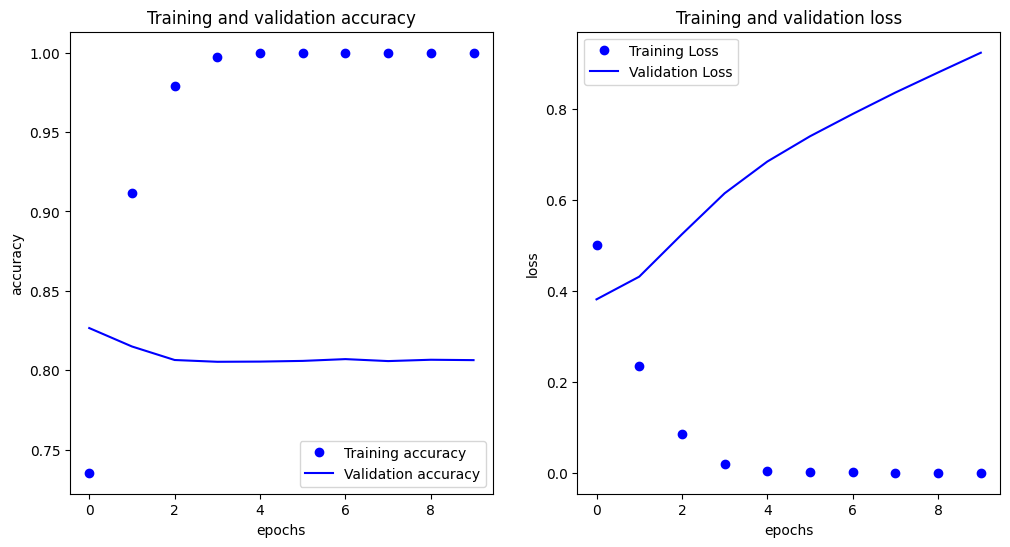

In [13]:
# Plot the accuracy and loss history
plot_loss_acc(history_flatten)

## LSTM

Next, you will use an LSTM. This is slower to train but useful in applications where the order of the tokens is important.

In [14]:
# Parameters
EMBEDDING_DIM = 16
LSTM_DIM = 32
DENSE_DIM = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [15]:
NUM_EPOCHS = 10

# Train the model
history_lstm = model_lstm.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10
782/782 [==============================] - 22s 17ms/step - loss: 0.6642 - accuracy: 0.6023 - val_loss: 0.6190 - val_accuracy: 0.6580
Epoch 2/10
782/782 [==============================] - 13s 17ms/step - loss: 0.6848 - accuracy: 0.5048 - val_loss: 0.6910 - val_accuracy: 0.5043
Epoch 3/10
782/782 [==============================] - 13s 16ms/step - loss: 0.6361 - accuracy: 0.6280 - val_loss: 0.6668 - val_accuracy: 0.5543
Epoch 4/10
782/782 [==============================] - 13s 16ms/step - loss: 0.6332 - accuracy: 0.6240 - val_loss: 0.6875 - val_accuracy: 0.5004
Epoch 5/10
782/782 [==============================] - 13s 16ms/step - loss: 0.6691 - accuracy: 0.5448 - val_loss: 0.6797 - val_accuracy: 0.5871
Epoch 6/10
782/782 [==============================] - 13s 16ms/step - loss: 0.6366 - accuracy: 0.6329 - val_loss: 0.6572 - val_accuracy: 0.6160
Epoch 7/10
782/782 [==============================] - 13s 16ms/step - loss: 0.6493 - accuracy: 0.5713 - val_loss: 0.6774 - val_accuracy:

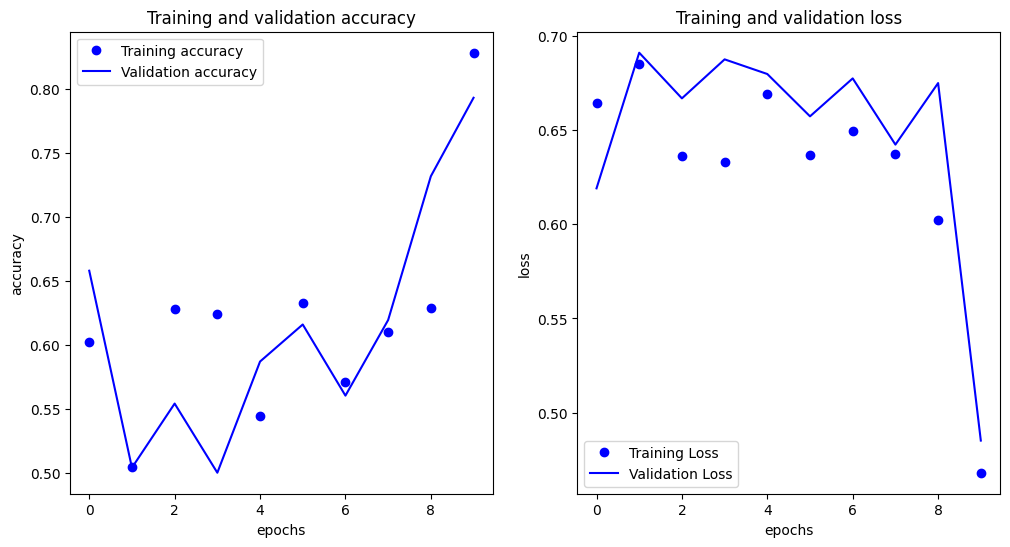

In [16]:
# Plot the accuracy and loss history
plot_loss_acc(history_lstm)

## GRU

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [17]:
# Parameters
EMBEDDING_DIM = 16
GRU_DIM = 32
DENSE_DIM = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(GRU_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [18]:
NUM_EPOCHS = 10

# Train the model
history_gru = model_gru.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=(test_dataset_final))

Epoch 1/10
782/782 [==============================] - 14s 16ms/step - loss: 0.5350 - accuracy: 0.7079 - val_loss: 0.4723 - val_accuracy: 0.7882
Epoch 2/10
782/782 [==============================] - 12s 15ms/step - loss: 0.3057 - accuracy: 0.8704 - val_loss: 0.4066 - val_accuracy: 0.8152
Epoch 3/10
782/782 [==============================] - 12s 15ms/step - loss: 0.2297 - accuracy: 0.9128 - val_loss: 0.4645 - val_accuracy: 0.8189
Epoch 4/10
782/782 [==============================] - 12s 15ms/step - loss: 0.1712 - accuracy: 0.9390 - val_loss: 0.5209 - val_accuracy: 0.8066
Epoch 5/10
782/782 [==============================] - 12s 15ms/step - loss: 0.1200 - accuracy: 0.9586 - val_loss: 0.6441 - val_accuracy: 0.8055
Epoch 6/10
782/782 [==============================] - 12s 15ms/step - loss: 0.0746 - accuracy: 0.9761 - val_loss: 0.7498 - val_accuracy: 0.7978
Epoch 7/10
782/782 [==============================] - 12s 15ms/step - loss: 0.0494 - accuracy: 0.9846 - val_loss: 0.8817 - val_accuracy:

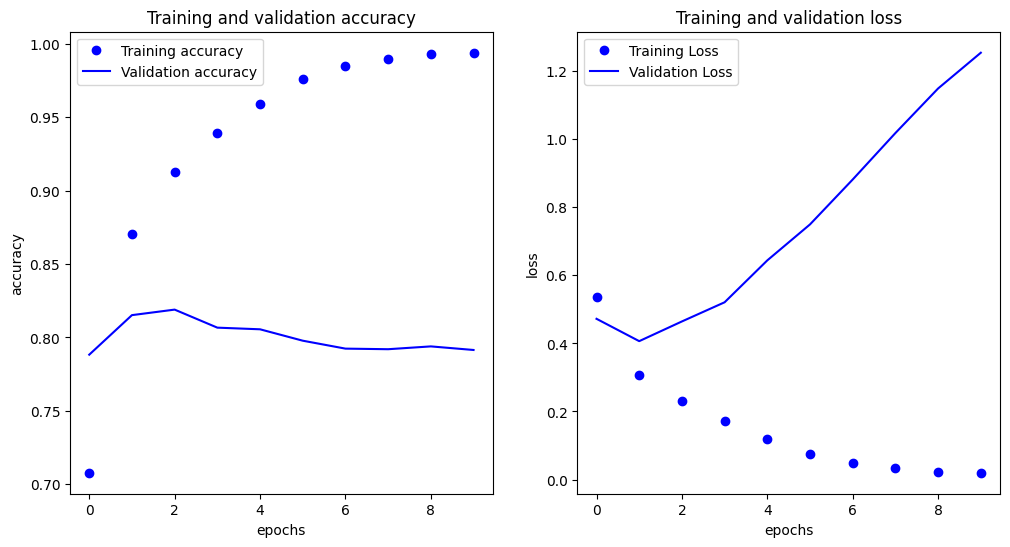

In [19]:
# Plot the accuracy and loss history
plot_loss_acc(history_gru)

## Convolution

Lastly, you will use a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

In [20]:
# Parameters
EMBEDDING_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [21]:
NUM_EPOCHS = 10

# Train the model
history_conv = model_conv.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=(test_dataset_final))

Epoch 1/10
782/782 [==============================] - 17s 8ms/step - loss: 0.5252 - accuracy: 0.7713 - val_loss: 0.4630 - val_accuracy: 0.8196
Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 0.3642 - accuracy: 0.8764 - val_loss: 0.4357 - val_accuracy: 0.8185
Epoch 3/10
782/782 [==============================] - 6s 7ms/step - loss: 0.2881 - accuracy: 0.9052 - val_loss: 0.4595 - val_accuracy: 0.8064
Epoch 4/10
782/782 [==============================] - 6s 7ms/step - loss: 0.2344 - accuracy: 0.9279 - val_loss: 0.5129 - val_accuracy: 0.8052
Epoch 5/10
782/782 [==============================] - 6s 7ms/step - loss: 0.1953 - accuracy: 0.9422 - val_loss: 0.6443 - val_accuracy: 0.8016
Epoch 6/10
782/782 [==============================] - 6s 7ms/step - loss: 0.1677 - accuracy: 0.9528 - val_loss: 0.6761 - val_accuracy: 0.7979
Epoch 7/10
782/782 [==============================] - 6s 7ms/step - loss: 0.1478 - accuracy: 0.9595 - val_loss: 0.8438 - val_accuracy: 0.7973
Epoch

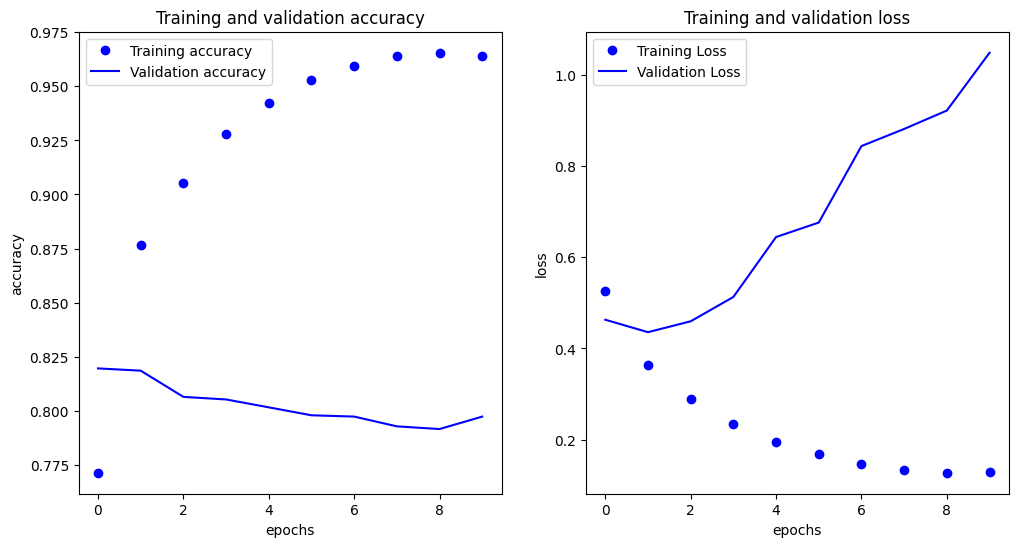

In [22]:
# Plot the accuracy and loss history
plot_loss_acc(history_conv)

## Wrap Up

Now that you've seen the results for each model, can you make a recommendation on what works best for this dataset? Do you still get the same results if you tweak some hyperparameters like the vocabulary size? Try tweaking some of the values some more so you can get more insight on what model performs best.

Run the cell below to free up resources for the next lab

In [23]:
# Shutdown the kernel to free up resources. 
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}